# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Preparations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

import seaborn as sns
import math
import json
%matplotlib inline

rcParams['figure.figsize'] = 12,8.5

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Part I - Data Check

#### 1. Portfolio

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


Portfolio Summary:
- small table with 10 rows and 6 columns
- channels is a list, we have two string coluns and rest are integers
- No nulls, no big outliers

#### 2. Profile

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [8]:
profile.shape

(17000, 5)

In [9]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


<AxesSubplot:>

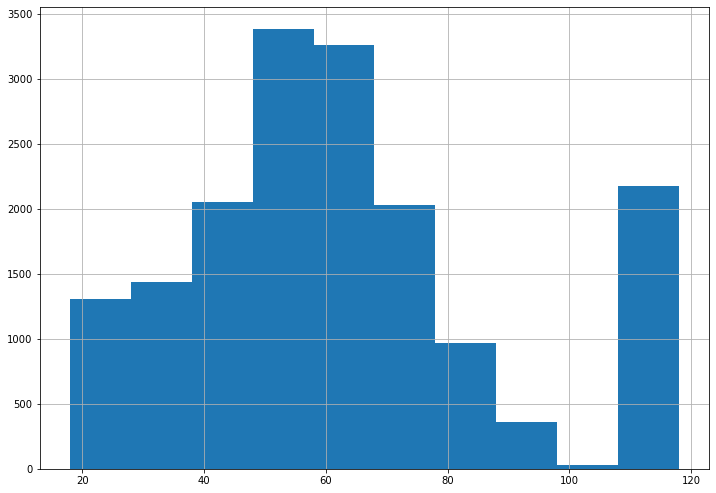

In [11]:
profile.age.hist()

In [12]:
profile.duplicated().sum()

0

In [13]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [14]:
#Age Column
profile[profile.age == 118][['gender','age','income']].count()

gender       0
age       2175
income       0
dtype: int64

Profile Summary:
- 17k rows, 5 columns
- All nulls in gender, income have age 118 - we can get rid of them

#### 3. Transcript

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.shape

(306534, 4)

In [17]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [18]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Transctipt summary:
- 306.5k rows and 4 columns
- no nulls
- value columns as dictonary

## Part II - Data Cleaning
- Clean each dataset
- Merge them into one

### Portfolio dataset
- change channels to dummys
- change offer_type to dummmys
- change id to offer id
- change duration to hours

In [19]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [20]:
#change channels to dummys
channels = portfolio['channels']
channels = pd.get_dummies(channels.apply(pd.Series).stack()).sum(level=0)
portfolio_clean = portfolio.join(channels)
portfolio_clean = portfolio_clean.drop('channels', 1)
portfolio_clean.head()

/var/folders/fj/_tf9b_g17230_2glmsbl3zr80000gp/T/ipykernel_12500/3502340713.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  channels = pd.get_dummies(channels.apply(pd.Series).stack()).sum(level=0)
/var/folders/fj/_tf9b_g17230_2glmsbl3zr80000gp/T/ipykernel_12500/3502340713.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  portfolio_clean = portfolio_clean.drop('channels', 1)


,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [21]:
#change offer_type to dummys
portfolio_clean = pd.get_dummies(portfolio_clean, columns=['offer_type'])
portfolio_clean.head()

,reward,difficulty,duration,id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [22]:
#change id to offer id
portfolio_clean = portfolio_clean.rename(columns = {'id':'offer_id'})
portfolio_clean.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [23]:
#change id to offer id
portfolio_clean.duration = portfolio_clean.duration*24
portfolio_clean.head()

,reward,difficulty,duration,offer_id,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [24]:
#assign to porftolio df
portfolio = portfolio_clean

### Profile dataset
- age outlier fix - delete
- became_member_on - date type and column name
- id to customer_id

In [25]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


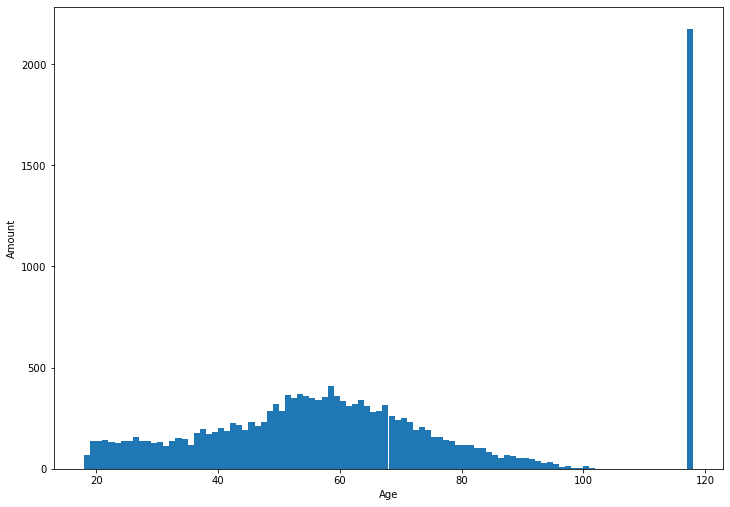

In [26]:
#Visualize age
plt.hist(profile.age, density=False, bins=100)
plt.ylabel('Amount')
plt.xlabel('Age');

In [27]:
#delete ages over 110
profile = profile[profile['age'] != 118]

In [28]:
# Became member change on to date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['became_member_on'].head()

1    2017-07-15
3    2017-05-09
5    2018-04-26
8    2018-02-09
12   2017-11-11
Name: became_member_on, dtype: datetime64[ns]

In [29]:
#rename id to customer_id
profile = profile.rename(columns = {'id':'customer_id'})
profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income'], dtype='object')

In [30]:
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


### Transcript dataset
- change value to offer_id or transaction to transaction_id, create dummy's
- change person to customer_id

In [31]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [32]:
transcript['event'] = transcript['event'].str.replace(' ', '_')

In [33]:
#rename person to customer_id
transcript = transcript.rename(columns = {'person':'customer_id'})
transcript.columns

Index(['customer_id', 'event', 'value', 'time'], dtype='object')

In [34]:
transcript = pd.get_dummies(transcript, columns=['event'])
transcript.head()

,customer_id,value,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,0,1,0,0


In [35]:
transcript['offer_id'] = [[*i.values()][0] if [*i.keys()][0] in ['offer id','offer_id'] else None for i in transcript.value]
transcript['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in transcript.value]

transcript = transcript.drop(columns='value')

In [36]:
transcript.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


#### Merging Datasets to one

In [37]:
p_t = pd.merge(transcript, portfolio, on='offer_id', how='left')
p_t.head()

,customer_id,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,offer_id,amount,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [38]:
df = pd.merge(profile, p_t, on='customer_id', how='right')
df.head()

,gender,age,customer_id,became_member_on,income,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,...,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,1,0,0,...,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaT,NaN,0,0,1,0,0,...,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,1,0,0,...,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,NaN,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaT,NaN,0,0,1,0,0,...,2.0,10.0,240.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,NaN,NaN,68617ca6246f4fbc85e91a2a49552598,NaT,NaN,0,0,1,0,0,...,10.0,10.0,120.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [39]:
df.isna().sum()

gender                       33772
age                          33772
customer_id                      0
became_member_on             33772
income                       33772
time                             0
event_offer_completed            0
event_offer_received             0
event_offer_viewed               0
event_transaction                0
offer_id                    138953
amount                      167581
reward                      138953
difficulty                  138953
duration                    138953
email                       138953
mobile                      138953
social                      138953
web                         138953
offer_type_bogo             138953
offer_type_discount         138953
offer_type_informational    138953
dtype: int64

In [40]:
# Drop NaN
df = df[df['age'].notna()]
df.isna().sum()

gender                           0
age                              0
customer_id                      0
became_member_on                 0
income                           0
time                             0
event_offer_completed            0
event_offer_received             0
event_offer_viewed               0
event_transaction                0
offer_id                    123957
amount                      148805
reward                      123957
difficulty                  123957
duration                    123957
email                       123957
mobile                      123957
social                      123957
web                         123957
offer_type_bogo             123957
offer_type_discount         123957
offer_type_informational    123957
dtype: int64

In [41]:
df.shape

(272762, 22)

In [42]:
df.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income', 'time',
       'event_offer_completed', 'event_offer_received', 'event_offer_viewed',
       'event_transaction', 'offer_id', 'amount', 'reward', 'difficulty',
       'duration', 'email', 'mobile', 'social', 'web', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational'],
      dtype='object')

In [43]:
df.head(20)

,gender,age,customer_id,became_member_on,income,time,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,...,reward,difficulty,duration,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational
0,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,0,0,1,0,0,...,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
2,M,68.0,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,0,0,1,0,0,...,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
5,M,65.0,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,0,0,1,0,0,...,5.0,5.0,120.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
7,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,0,0,1,0,0,...,0.0,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
8,F,61.0,aa4862eba776480b8bb9c68455b8c2e1,2017-09-11,57000.0,0,0,1,0,0,...,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,F,62.0,31dda685af34476cad5bc968bdb01c53,2016-02-11,71000.0,0,0,1,0,0,...,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
12,M,64.0,4b0da7e80e5945209a1fdddfe813dbe0,2017-09-09,100000.0,0,0,1,0,0,...,10.0,10.0,168.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
13,F,78.0,c27e0d6ab72c455a8bb66d980963de60,2017-06-16,71000.0,0,0,1,0,0,...,0.0,0.0,96.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
14,F,88.0,d53717f5400c4e84affdaeda9dd926b3,2017-05-18,53000.0,0,0,1,0,0,...,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
15,M,42.0,f806632c011441378d4646567f357a21,2013-08-11,69000.0,0,0,1,0,0,...,2.0,10.0,240.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


## Part III - Exploratory Data Analysis

### 1. How looks distribution of genders?

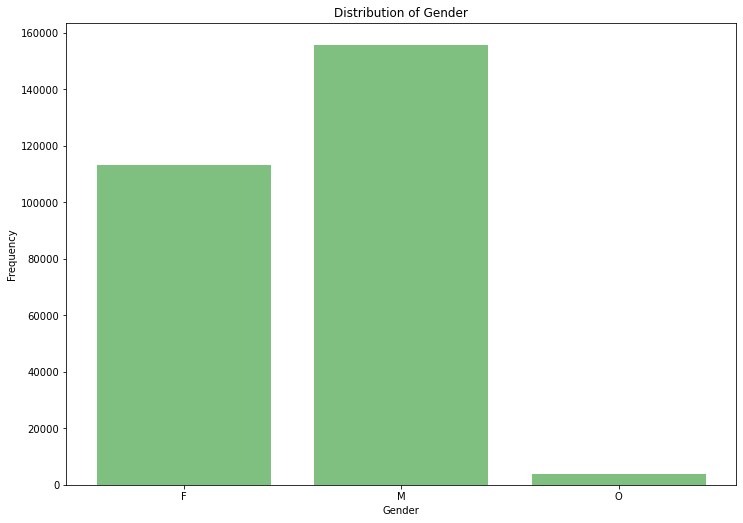

In [48]:
gender = df[['gender', 'customer_id']].groupby('gender').count()
labels = gender.index
X = np.arange(len(gender))
Y = gender['customer_id']
plt.bar(X, Y, facecolor='g', alpha=0.5)
plt.xticks(X, labels)
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Distribution of Gender');

### 2. How does an income distribution looks like?

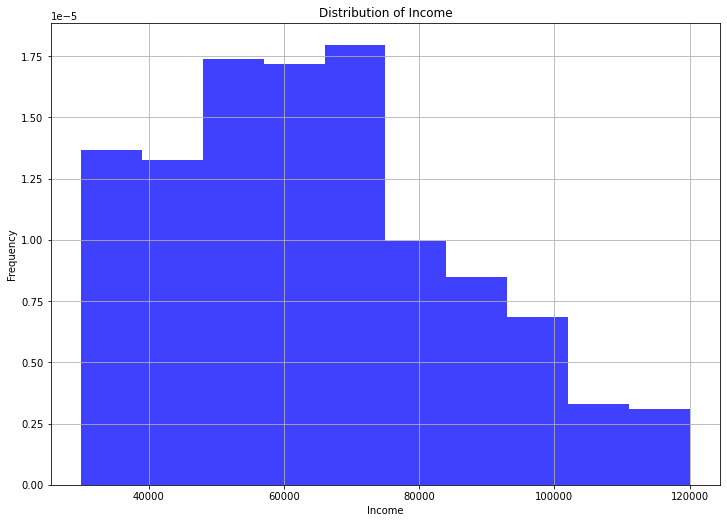

In [45]:
df.income.hist(density=True, facecolor='b', alpha=0.5)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency');

### 3. How does age distribution looks like?

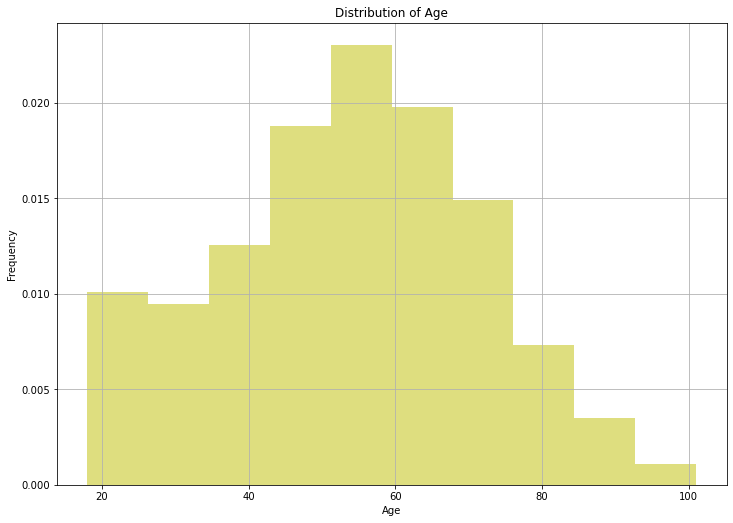

In [52]:
df.age.hist(density=True, facecolor='y', alpha=0.5)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency');

### 4. How looks distribution of events?

Text(0, 0.5, 'Frequency')

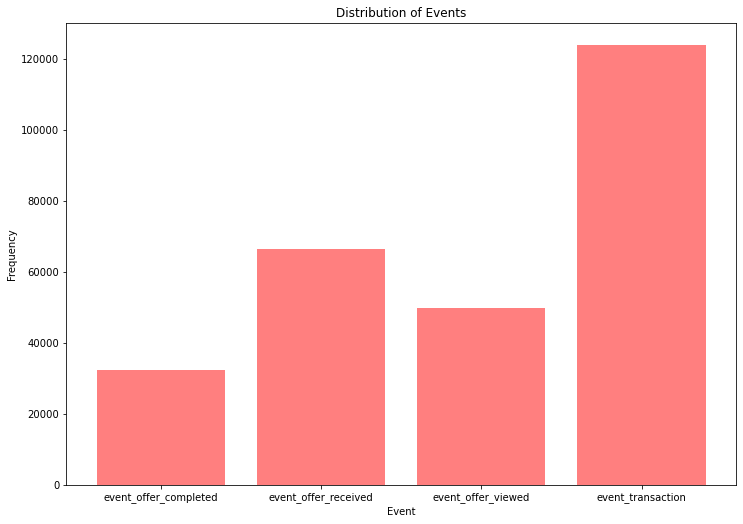

In [51]:
events = df[['event_offer_completed', 'event_offer_received', 'event_offer_viewed',
       'event_transaction']].sum()
labels = events.index
X = np.arange(len(labels))
Y = events
plt.bar(X, Y, facecolor='r', alpha=0.5)
plt.title('Distribution of Events')
plt.xticks(X, labels)
plt.xlabel('Event')
plt.ylabel('Frequency')